setup 

In [39]:
from FireSimulator import *

import copy
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import operator
import os
import pdb
import pickle
import sys
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


function to visualize forest

In [11]:
def visualize_forest(axis_handle, data):
    r, c = data.shape
    
    rectangles = {}
    for i in range(r):
        for j in range(c):
            x = col_to_x(j)
            y = row_to_y(grid_size,i)
            rectangles[(i,j)] = patches.Rectangle((x-0.5,y-0.5),1,1,alpha=0.6)
        
    
    for i in range(r):
        for j in range(c):

            rect = rectangles[(i,j)]

            if data[i,j] == 0:
                rect.set_color('g')
            elif data[i,j] == 1:
                rect.set_color('r')
            elif data[i,j] == 2:
                rect.set_color('k')

            axis_handle.add_patch(rect)
  
    return axis_handle

simulation parameters

In [21]:
grid_size = 2
dp = 0
alpha = 0.2763
beta = np.exp(-0.1)

nn = [(-1,0),(1,0),(0,-1),(0,1)]

neighbors = {}
for i in range(grid_size):
    for j in range(grid_size):
        neighbors[(i,j)] = []
        
        for (di,dj) in nn:
            ii = i + di
            jj = j + dj
            if ii>=0 and ii<grid_size and jj>=0 and jj<grid_size:
                neighbors[(i,j)].append((ii,jj))

point-to-point measurement function

In [22]:
meas_right = 0.9
meas_wrong = 0.5*(1-meas_right)
def measurement(xi_t, yi_t):
    if xi_t != yi_t:
        return meas_wrong
    elif xi_t == yi_t:
        return meas_right

helper function to generate 'reachable' (non-zero probability) states from a given state

In [23]:
def ReachableStates(state, neighbors):
    Rstates = {}
    num_nodes = len(state)
    dim = int(np.sqrt(num_nodes))
    
    def generate(Rstates, state, el = 0, p = 1):
        
        if el < num_nodes:
            if state[el] == 0:
                nnof = 0
                row, col = np.unravel_index(el,(dim,dim),order='C')
                
                for (r,c) in neighbors[(row,col)]:
                    n_ind = np.ravel_multi_index([[r],[c]],(dim,dim),order='C')
                    if state[n_ind] == 1:
                        nnof += 1
                
                if nnof == 0:
                    generate(Rstates, state, el=el+1, p = p)
                    return
                
                pmod = (1-alpha)**nnof
                
                mod_state = copy.copy(state)
                mod_state[el] += 1
                generate(Rstates, mod_state, el=el+1, p=p*(1-pmod))
                
                generate(Rstates, state, el=el+1, p=p*pmod)
                return 
            
            elif state[el] == 1:
                mod_state = copy.copy(state)
                mod_state[el] += 1
                generate(Rstates, mod_state, el=el+1, p=p*(1-beta))

                generate(Rstates, state, el=el+1, p=p*beta)
                return 

            elif state[el] == 2:
                generate(Rstates, state, el=el+1, p=p)
                return 
        
        else:
            key = ''.join(str(e) for e in state)
            Rstates[key] = p
            return 
        
    generate(Rstates, state)
    return Rstates
            

exact Bayes filter implementation

In [24]:
def exact_method(belief, neighbors, grid_size, meas_data):
    
    next_belief = {}
    
    p_xt = {}
    for i in range(3**(grid_size**2)):
        x_tm1 = np.base_repr(i, base=3).zfill(grid_size**2)
        
        x_tm1_arr = np.array(list(x_tm1), dtype=int)
        Rstates = ReachableStates(x_tm1_arr, neighbors)
        for key in Rstates.keys():
            p_xt.setdefault(key, 0)
            p_xt[key] += Rstates.get(key, 0)*belief[x_tm1]
            
    normalize = 0
    for i in range(3**(grid_size**2)):
        x_t = np.base_repr(i, base=3).zfill(grid_size**2)
        next_belief[x_t] = 0
        
        meas_prob = 1
        for el in range(grid_size**2):
            row, col = np.unravel_index(el,(grid_size,grid_size),order='C')
            meas_prob *= measurement(int(x_t[el]), meas_data[row,col])
            
        next_belief[x_t] = meas_prob * p_xt.get(x_t, 0)
        normalize += next_belief[x_t]
        
    for key in next_belief:
        next_belief[key] /= normalize
    
    return next_belief

run a simulation

In [25]:
np.random.seed(1000)

fire_init = [(int(grid_size/2)+1,int(grid_size/2)+1)]
sim = FireSimulator(grid_size, alpha=alpha, beta=beta, fire_init=fire_init)

belief = {}
# uniform initial belief
for i in range(3**(grid_size**2)):
    x = np.base_repr(i, base=3).zfill(grid_size**2)
    belief[x] = 1./(3**(grid_size**2))
    
# exact initial belief
for i in range(3**(grid_size**2)):
    x = np.base_repr(i, base=3).zfill(grid_size**2)
    belief[x] = 0
state_str = ''.join([str(e) for e in ])

meas_data = sim.state

state_est_str = '0' * grid_size**2 
state_est = np.array(list(state_est_str), dtype=int).reshape(grid_size,grid_size)

meas_errors = []
state_errors = []

plotting = False

if plotting:
    fig = plt.figure(figsize=(15,15))

    ax1 = fig.add_subplot(131, aspect='equal')
    ax1.set_xlim([0,grid_size+1])
    ax1.set_ylim([0,grid_size+1])
    plt.title('ground truth\nt = %d' %sim.iter)
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax1 = visualize_forest(ax1, sim.state)

    ax2 = fig.add_subplot(132, aspect='equal')
    ax2.set_xlim([0,grid_size+1])
    ax2.set_ylim([0,grid_size+1])
    plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_data != sim.state),sim.iter))
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    ax2 = visualize_forest(ax2, meas_data)

    ax3 = fig.add_subplot(133, aspect='equal')
    ax3.set_xlim([0,grid_size+1])
    ax3.set_ylim([0,grid_size+1])
    plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
    plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est != sim.state),sim.iter))
    ax3 = visualize_forest(ax3, state_est)
    
    rows, cols = np.where(state_est != sim.state)
    for i, j in zip(rows, cols):
        x = col_to_x(j)
        y = row_to_y(grid_size, i)
        plt.plot(x, y, marker='o', color='b')
                
tic = time.clock()
# for _ in range(1):
while not sim.end:
    
    sim.step([], dbeta=dp)
    
    meas_data = np.zeros_like(sim.state) + -1
    for i in range(grid_size):
        for j in range(grid_size):
            
            meas = sim.state[i,j]
            p_list = [meas_wrong,meas_wrong,meas_wrong]
            p_list[meas] += meas_right - meas_wrong
            meas_data[i,j] = np.random.choice([0,1,2], p=p_list)
    
    belief = exact_method(belief, neighbors, grid_size, meas_data)

    state_est_str = max(belief.items(), key=operator.itemgetter(1))[0]
    state_est = np.array(list(state_est_str), dtype=int).reshape(grid_size,grid_size)
    
    state_errors.append(np.sum(state_est != sim.state))
    meas_errors.append(np.sum(meas_data != sim.state))
    
    if plotting:
        fig = plt.figure(figsize=(15,15))

        ax1 = fig.add_subplot(131, aspect='equal')
        ax1.set_xlim([0,grid_size+1])
        ax1.set_ylim([0,grid_size+1])
        plt.title('ground truth\nt = %d' %sim.iter)
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        ax1 = visualize_forest(ax1, sim.state)

        ax2 = fig.add_subplot(132, aspect='equal')
        ax2.set_xlim([0,grid_size+1])
        ax2.set_ylim([0,grid_size+1])
        plt.title('measurement: %d error(s)\nt = %d' %(np.sum(meas_data != sim.state),sim.iter))
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        ax2 = visualize_forest(ax2, meas_data)

        ax3 = fig.add_subplot(133, aspect='equal')
        ax3.set_xlim([0,grid_size+1])
        ax3.set_ylim([0,grid_size+1])
        plt.tick_params(axis='both', which='both', labelbottom=False, labelleft=False, bottom=False, left=False)
        plt.title('estimate: %d error(s)\nt = %d' %(np.sum(state_est != sim.state),sim.iter))
        ax3 = visualize_forest(ax3, state_est)

        rows, cols = np.where(state_est != sim.state)
        for i, j in zip(rows, cols):
            x = col_to_x(j)
            y = row_to_y(grid_size, i)
            plt.plot(x, y, marker='o', color='b')
            
    #print('sim iteration:',sim.iter)
    
toc = time.clock()
print('number of sim iterations',sim.iter)
print('median percent error: %0.3f' %(np.median(state_errors)*100/grid_size**2))
print('mean percent error: %0.3f' %(np.mean(state_errors)*100/grid_size**2))
print('max percent error: %0.3f' %(np.amax(state_errors)*100/grid_size**2))
print('min percent error: %0.3f' %(np.amin(state_errors)*100/grid_size**2))
print('%0.2fs = %0.2fm elapsed' % (toc-tic,(toc-tic)/60))

number of sim iterations 10
median percent error: 0.000
mean percent error: 8.333
max percent error: 25.000
min percent error: 0.000
0.13s = 0.00m elapsed


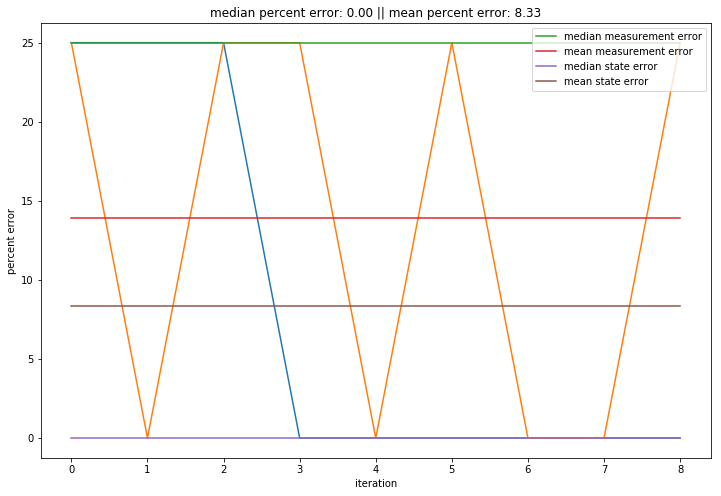

In [26]:
plot_state_errors = [100*e/grid_size**2 for e in state_errors]
plot_meas_errors = [100*e/grid_size**2 for e in meas_errors]

plt.figure(figsize=(12,8))
plt.plot(plot_state_errors)
plt.plot(plot_meas_errors)
plt.plot(range(len(plot_meas_errors)),np.median(plot_meas_errors)*np.ones(len(plot_meas_errors)), \
         label='median measurement error')
plt.plot(range(len(plot_meas_errors)),np.mean(plot_meas_errors)*np.ones(len(plot_meas_errors)), \
         label='mean measurement error')
plt.plot(range(len(plot_state_errors)),np.median(plot_state_errors)*np.ones(len(plot_state_errors)), \
         label='median state error')
plt.plot(range(len(plot_state_errors)),np.mean(plot_state_errors)*np.ones(len(plot_state_errors)), \
         label='mean state error')

plt.title('median percent error: %0.2f || mean percent error: %0.2f' \
          %(np.median(state_errors)*100/grid_size**2,np.mean(state_errors)*100/grid_size**2))
plt.ylabel('percent error')
plt.xlabel('iteration')

plt.legend(loc=1)

benchmark

In [44]:
grid_size = 2
total_sims = 20

results = {}
results['grid_size'] = grid_size

neighbors = {}
for i in range(grid_size):
    for j in range(grid_size):
        neighbors[(i,j)] = []
        
        for (di,dj) in nn:
            ii = i + di
            jj = j + dj
            if ii>=0 and ii<grid_size and jj>=0 and jj<grid_size:
                neighbors[(i,j)].append((ii,jj))

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] start' %st)

tic = time.clock()
for idx,s in enumerate(range(total_sims)):
    seed = s+1000
    np.random.seed(seed)
    results[seed] = {}
    results[seed]['state_error'] = []
    results[seed]['meas_error'] = []
    
    # sim = FireSimulator(grid_size, alpha=alpha, beta=beta)
    # sim.step([])

    fire_init = [(int(grid_size/2)+1,int(grid_size/2)+1)]
    sim = FireSimulator(grid_size, alpha=alpha, beta=beta, fire_init=fire_init)
    
    belief = {}
    # uniform initial belief
    # for i in range(3**(grid_size**2)):
    #     x = np.base_repr(i, base=3).zfill(grid_size**2)
    #     belief[x] = 1./(3**(grid_size**2))
        
    # exact initial belief
    for i in range(3**(grid_size**2)):
        x = np.base_repr(i, base=3).zfill(grid_size**2)
        belief[x] = 0
    state_str = ''.join([str(e) for e in sim.state.reshape((grid_size**2,))])
    belief[state_str] = 1

    while not sim.end:
    # for _ in range(1):
        # if sim.iter > 1:
        sim.step([])

        meas_data = np.zeros_like(sim.state) + -1
        for i in range(grid_size):
            for j in range(grid_size):

                meas = sim.state[i,j]
                p_list = [meas_wrong,meas_wrong,meas_wrong]
                p_list[meas] += meas_right - meas_wrong
                meas_data[i,j] = np.random.choice([0,1,2], p=p_list)

        belief = exact_method(belief, neighbors, grid_size, meas_data)

        state_est_str = max(belief.items(), key=operator.itemgetter(1))[0]
        state_est = np.array(list(state_est_str), dtype=int).reshape(grid_size,grid_size)

        results[seed]['state_error'].append(np.sum(state_est != sim.state))
        results[seed]['meas_error'].append(np.sum(meas_data != sim.state))
        
    if (idx+1) % 10 == 0:
        st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
        print('[%s] finished %d simulations' %(st, idx+1))
        
        filename = '[SAVE] ' + 'ex_gs' + str(grid_size) + '_s' + str(idx+1) + '.pkl'
        output = open(filename, 'wb')
        pickle.dump(results, output)
        output.close()

st = datetime.today().strftime('%Y-%m-%d %H:%M:%S')
print('[%s] finish' %st)
        
toc = time.clock()
print('%0.2fs = %0.2fm elapsed' % (toc-tic,(toc-tic)/60))

filename = 'ex_gs' + str(grid_size) + '_s' + str(total_sims) + '.pkl'
output = open(filename, 'wb')
pickle.dump(results, output)
output.close()

[2018-07-18 17:40:56] start
[2018-07-18 17:40:57] finished 10 simulations
[2018-07-18 17:40:59] finished 20 simulations
[2018-07-18 17:40:59] finish
3.51s = 0.06m elapsed


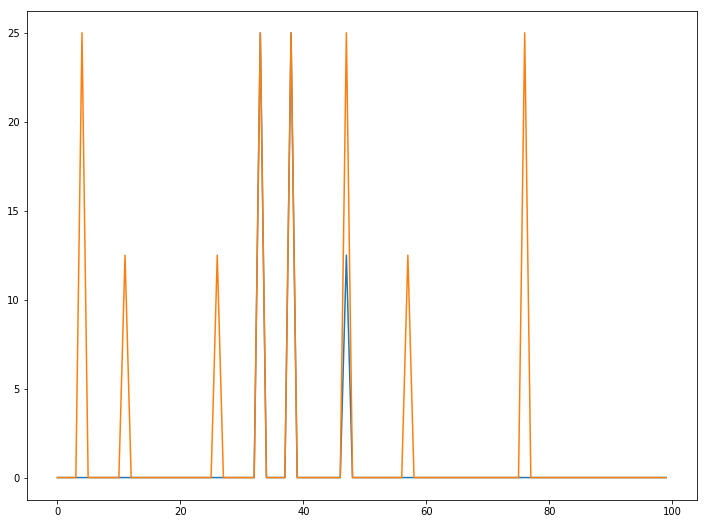

In [41]:
state_error_plot = [np.median(results[s]['state_error'])*100/grid_size**2 for s in results.keys() if isinstance(s, int)]
meas_error_plot = [np.median(results[s]['meas_error'])*100/grid_size**2 for s in results.keys() if isinstance(s, int)]

plt.figure(figsize=(12,9))
plt.plot(state_error_plot)
plt.plot(meas_error_plot)